In [ ]:
"""
Changes from OHE: 
-Here we drop features based on low correlation with the target(0.1 threshold whereas in OHE was 0.2)
-We drop correlated features(the one of the two less correlated with the target) from 0.9 correlation(before was 0.85)
-Here we just try lambda = 1e-8
"""

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
from Data_cleaning import *
from helpers import *
from exploratory_data_analysis import *
from preprocessing import *

In [2]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("data\dataset\dataset")

In [28]:
Y_tr = (y_train + 1) / 2

In [29]:
X_train, keep_mask = remove_nan_features(x_train, 0.2)
X_test = x_test[:, keep_mask]

In [30]:
print(X_train.shape, X_test.shape)

(328135, 143) (109379, 143)


In [31]:
cat_mask, num_mask = detect_categorical_features(X_train, max_unique=10)

In [32]:
print(np.sum(cat_mask), np.sum(num_mask))

99 44


In [33]:
x_tr, y_tr, x_va, y_va, x_te, y_te = stratified_three_way_split(X_train, Y_tr)

In [34]:
print(X_train.shape, x_tr.shape, y_tr.shape, x_va.shape, y_va.shape, x_te.shape, y_te.shape)

(328135, 143) (229695, 143) (229695,) (49220, 143) (49220,) (49220, 143) (49220,)


In [35]:
# Numerical imputation (compute medians from training)
x_tr_imp, medians = impute_numerical(x_tr, num_mask)
# Apply same medians to val/test
x_va_imp, _ = impute_numerical(x_va, num_mask, medians)
x_te_imp, _ = impute_numerical(x_te, num_mask, medians)
x_test_imp, _ = impute_numerical(X_test, num_mask, medians)
# Categorical imputation (compute modes from training)
x_tr_imp, modes = impute_categorical(x_tr_imp, cat_mask)
# Apply same modes to val/test
x_va_imp, _ = impute_categorical(x_va_imp, cat_mask, modes)
x_te_imp, _ = impute_categorical(x_te_imp, cat_mask, modes)
x_test_imp, _ = impute_categorical(x_test_imp, cat_mask, modes)

In [36]:
# Check for any remaining NaN values
print(np.isnan(x_tr_imp).sum(),
      np.isnan(x_va_imp).sum(),
      np.isnan(x_te_imp).sum(), np.isnan(x_test_imp).sum())

0 0 0 0


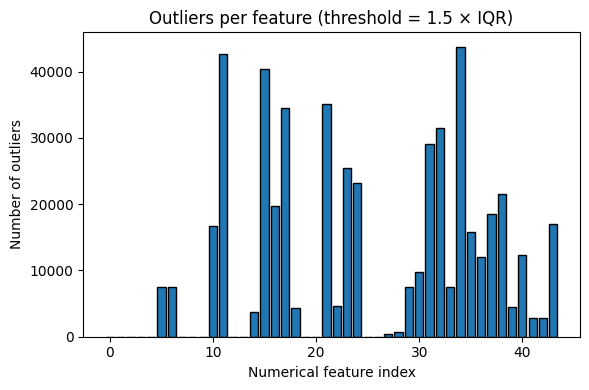

In [37]:
outlier_mask, outlier_counts = detect_outliers(x_tr_imp, num_mask, threshold=1.5, plot=True)

In [38]:
print(outlier_counts)

[    0     0     0     0     0  7523  7523     0     0     0 16765 42722
     0     0  3745 40468 19668 34545  4275     0     0 35062  4608 25522
 23171     0     0   441   754  7544  9823 29058 31441  7525 43748 15806
 12023 18456 21474  4498 12403  2772  2772 16957]


In [39]:
outlier_pctg = outlier_counts / x_tr_imp.shape[0]
print(outlier_pctg)

[0.         0.         0.         0.         0.         0.03275213
 0.03275213 0.         0.         0.         0.07298809 0.18599447
 0.         0.         0.01630423 0.17618146 0.08562659 0.15039509
 0.01861164 0.         0.         0.1526459  0.02006139 0.11111256
 0.10087725 0.         0.         0.00191994 0.00328261 0.03284355
 0.04276541 0.12650689 0.13688152 0.03276084 0.19046126 0.06881299
 0.05234332 0.08035003 0.09348919 0.01958249 0.05399769 0.01206818
 0.01206818 0.07382398]


In [40]:
drop_threshold = 0.1
new_num_mask = outlier_pctg < drop_threshold


In [41]:
#Change the mask again
keep_mask = np.ones(x_tr_imp.shape[1], dtype=bool)
num_indices = np.where(num_mask)[0]
keep_mask[num_indices] = new_num_mask

In [42]:
x_tr_filt = x_tr_imp[:, keep_mask]
x_va_filt = x_va_imp[:, keep_mask]
x_te_filt = x_te_imp[:, keep_mask]
x_test_filt = x_test_imp[:, keep_mask]
num_mask = num_mask[keep_mask]
cat_mask = cat_mask[keep_mask]

In [43]:
print(np.sum(num_mask), np.sum(cat_mask))

35 99


In [44]:
# Fit one-hot encoder on training data
x_tr_enc, categories = one_hot_encode(x_tr_filt, cat_mask, drop_first=True)

# Apply the same categories to validation and test data
x_va_enc, _ = one_hot_encode(x_va_filt, cat_mask, categories, drop_first=True)
x_te_enc, _ = one_hot_encode(x_te_filt, cat_mask, categories, drop_first=True)
x_test_enc, _ = one_hot_encode(x_test_filt, cat_mask, categories, drop_first=True)

In [45]:
print(x_tr_enc.shape, x_va_enc.shape, x_te_enc.shape, x_test_enc.shape) 

(229695, 359) (49220, 359) (49220, 359) (109379, 359)


In [46]:
cat_mask_enc, num_mask_enc = detect_categorical_features(x_tr_enc, max_unique=10)

In [47]:
print(np.sum(cat_mask_enc), np.sum(num_mask_enc))

324 35


In [48]:
print(np.max(x_tr_enc[:,cat_mask_enc]))

1.0


In [49]:
x_tr_std, means, stds = standardize_features(x_tr_enc, num_mask_enc)
x_va_std, _, _ = standardize_features(x_va_enc, num_mask_enc, means, stds)
x_te_std, _, _ = standardize_features(x_te_enc, num_mask_enc, means, stds)
x_test_std, _, _ = standardize_features(x_test_enc, num_mask_enc, means, stds)

In [50]:
corr_y = feature_target_correlation_2(x_tr_std, y_tr)


In [51]:
min_corr = 0.01
keep_mask_corr = np.abs(corr_y) > min_corr


In [52]:
x_tr_sel = x_tr_std[:, keep_mask_corr]
x_va_sel = x_va_std[:, keep_mask_corr]
x_te_sel = x_te_std[:, keep_mask_corr]
x_test_sel = x_test_std[:, keep_mask_corr]

In [53]:
print(x_tr_sel.shape, x_va_sel.shape, x_te_sel.shape, x_test_sel.shape)

(229695, 209) (49220, 209) (49220, 209) (109379, 209)


In [54]:
cat_mask_sel, num_mask_sel = detect_categorical_features(x_tr_sel, max_unique=10)

In [55]:
print(np.sum(cat_mask_sel))

183


In [56]:
corr_mat = correlation_matrix(x_tr_sel)


In [57]:
threshold = 0.9
to_drop = set()

for i in range(corr_mat.shape[0]):
    for j in range(i + 1, corr_mat.shape[1]):
        if abs(corr_mat[i, j]) > threshold:
            # Compare absolute correlation with y
            if abs(corr_y[i]) < abs(corr_y[j]):
                to_drop.add(i)
            else:
                to_drop.add(j)

keep_mask_inter = np.ones(x_tr_sel.shape[1], dtype=bool)
keep_mask_inter[list(to_drop)] = False



In [58]:
x_tr_final = x_tr_sel[:, keep_mask_inter]
x_va_final = x_va_sel[:, keep_mask_inter]
x_te_final = x_te_sel[:, keep_mask_inter]
x_test_final = x_test_sel[:, keep_mask_inter]

In [59]:
print("Dropped (low corr):", np.sum(~keep_mask_corr))
print("Dropped (high inter):", np.sum(~keep_mask_inter))
print("Remaining features:", x_tr_final.shape[1])


Dropped (low corr): 150
Dropped (high inter): 37
Remaining features: 172


In [60]:
best_params, best_f1, results = grid_search(
    y_tr, x_tr_final,
    y_va, x_va_final,
    pos_weights=[9, 9.5, 10],
    lambdas=[1e-8],
    thresholds=np.linspace(0.5, 0.85, 200),
    max_iter=10000,
    gamma=0.5
)



=== Run 1/3 (pos_weight=9, lambda_=1e-08) ===
New best F1 = 0.3839
New best F1 = 0.3842
New best F1 = 0.3853
New best F1 = 0.3865
New best F1 = 0.3873
New best F1 = 0.3878
New best F1 = 0.3882
New best F1 = 0.3886
New best F1 = 0.3891
New best F1 = 0.3899
New best F1 = 0.3903
New best F1 = 0.3913
New best F1 = 0.3916
New best F1 = 0.3921
New best F1 = 0.3923
New best F1 = 0.3930
New best F1 = 0.3933
New best F1 = 0.3941
New best F1 = 0.3943
New best F1 = 0.3946
New best F1 = 0.3947
New best F1 = 0.3958
New best F1 = 0.3959
New best F1 = 0.3970
New best F1 = 0.3972
New best F1 = 0.3975
New best F1 = 0.3978
New best F1 = 0.3982
New best F1 = 0.3989
New best F1 = 0.3991
New best F1 = 0.4002
New best F1 = 0.4006
New best F1 = 0.4010
New best F1 = 0.4013
New best F1 = 0.4015
New best F1 = 0.4028
New best F1 = 0.4034
New best F1 = 0.4038
New best F1 = 0.4038
New best F1 = 0.4041
New best F1 = 0.4045
New best F1 = 0.4048
New best F1 = 0.4051
New best F1 = 0.4052
New best F1 = 0.4055
New best

In [61]:
X_final = np.vstack([x_tr_final, x_va_final])
y_final = np.concatenate([y_tr, y_va])


In [63]:
best_lambda = 1e-8
best_pos_weight = 10.0
best_neg_weight = 1.0
best_threshold = 0.7374371859296482

final_loss, w_final = logistic_regression_weighted_gd(
    y_final, X_final,
    lambda_=best_lambda,
    gamma=0.5,
    pos_weight=best_pos_weight,
    neg_weight=best_neg_weight,
    max_iter=10000,
    verbose=True
)

print("Final training loss:", final_loss)


Iter     0 | Loss = 0.693147 | GradNorm = 0.4292
Iter   100 | Loss = 0.478867 | GradNorm = 0.0120
Iter   200 | Loss = 0.474631 | GradNorm = 0.0072
Iter   300 | Loss = 0.472719 | GradNorm = 0.0054
Iter   400 | Loss = 0.471545 | GradNorm = 0.0044
Iter   500 | Loss = 0.470717 | GradNorm = 0.0038
Iter   600 | Loss = 0.470088 | GradNorm = 0.0033
Iter   700 | Loss = 0.469591 | GradNorm = 0.0030
Iter   800 | Loss = 0.469188 | GradNorm = 0.0027
Iter   900 | Loss = 0.468857 | GradNorm = 0.0025
Iter  1000 | Loss = 0.468581 | GradNorm = 0.0022
Iter  1100 | Loss = 0.468349 | GradNorm = 0.0021
Iter  1200 | Loss = 0.468153 | GradNorm = 0.0019
Iter  1300 | Loss = 0.467986 | GradNorm = 0.0018
Iter  1400 | Loss = 0.467843 | GradNorm = 0.0016
Iter  1500 | Loss = 0.467720 | GradNorm = 0.0015
Iter  1600 | Loss = 0.467613 | GradNorm = 0.0014
Iter  1700 | Loss = 0.467520 | GradNorm = 0.0013
Iter  1800 | Loss = 0.467439 | GradNorm = 0.0012
Iter  1900 | Loss = 0.467368 | GradNorm = 0.0012
Iter  2000 | Loss = 

In [64]:
print(w_final @ w_final)

19.26669311507094


In [66]:
acc, f1 = evaluate_model(y_te, x_te_final, w_final, best_threshold)

 Accuracy: 87.74%
 F1 Score: 0.4252


Confusion Matrix:
[[40954  3920]
 [ 2114  2232]]
TN=40954, FP=3920, FN=2114, TP=2232


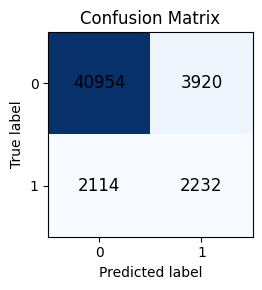

In [67]:
preds, _ = predict_with_threshold(x_te_final, w_final, threshold=best_threshold)
cm = confusion_matrix_numpy(y_te, preds)

In [68]:
y_pred_final, _ = predict_with_threshold(x_test_final, w_final, best_threshold)
y_pred_final = 2 * y_pred_final - 1   # converts 0→-1, 1→1

create_csv_submission(test_ids, y_pred_final, "ModelOHE2_preds.csv")